In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import time

In [7]:
def create_random_preferences(M, W, T=True, I=True):
    #preference arrays may contain ties and missing values
    prefs = np.zeros((M,W)) #initialize preference lists
    
    for i in range(M): #for each man
        row = np.empty(W)
        row[:] = np.inf #initialize row with inf, to denote that every value is a missing value
        rank = 0 #initial ranking
        non_I = np.random.randint(W//2,W) if I else W #number of mising values is random, uniform between w//2 an w
        for j in range(non_I): 
            row[j] = rank #woman[j] has rank rank
            rank += np.random.randint(0,2) if T else 1 #decide if next woman will have the same or increased rank, if ranks stays the same a tie exists
        prefs[i] = np.random.permutation(row) #shuffle row
    return prefs

In [4]:
def Extended_Gale_Shapley(men_prefs, women_prefs):
    M = men_prefs.shape[0]
    W = women_prefs.shape[0]
    x = np.zeros((M,W)) #initialize matchings array
    men_prefs = np.copy(men_prefs)
    women_prefs = np.copy(women_prefs)
    
    bachelors = [i for i in range(M)] #everyone is free at start
    
    while bachelors:
        proposals = [np.random.choice(np.where(i==np.min(i))[0]) for i in men_prefs] #get the most desired women, break ties arbitarily
        free_men = [i for i in bachelors if not (men_prefs[i]==np.inf).all()] #if a man has no match and has women left to propose to is free
        if not free_men: #if no more free men terminate
            break

        for man in free_men: #for each free man
            wife = proposals[man] #get his most desired woman
            if women_prefs[wife,man] == np.inf: #if man not in woman's list
                men_prefs[man,wife] = np.inf #remove woman from man's list
            else:
                if np.sum(x[:,wife])>0: #if woman already has a husband
                    old_husband = np.where(x[:,wife]==1)[0][0] #find the old husband
                    x[old_husband,wife]=0 #break old pair
                    bachelors.append(old_husband) #mark old man as bachelor
    
                x[man,wife] = 1 #add new pair
                successors = women_prefs[wife] >= women_prefs[wife,man] #find all men woman prefers less than man
                men_prefs[successors,wife] = np.inf #set woman to inf on all men's lists
                women_prefs[wife][successors] = np.inf #set all successors to inf on woman's lists
                bachelors.remove(man) #remove man froom bachelors
        
    return x

In [5]:
def is_weakly_stable(x, men_prefs, women_prefs):
    #tests for weak stability
    M,W = x.shape
    man_ismatched = np.sum(x,axis=1)
    woman_ismatched = np.sum(x,axis=0)
    if (((women_prefs.T) + men_prefs)[np.where(x==1)] == np.inf).any(): #test if any impossible pairs exist
        print('impossible match')
        return False
    for i in range(M):
        for j in range(W):#for each pair
            if men_prefs[i,j] == np.inf or women_prefs[j,i] == np.inf: #check if is possible
                None
            else: #find man's current wife if man is married and woman's current hsuband if she is married
                current_wife = np.where(x[i]==1)[0] if man_ismatched[i]==1 else 0
                current_husband = np.where(x[:,j]==1)[0] if woman_ismatched[j]==1 else 0
                
                #if man prefers woman over wife or is free and woman prefers man over husband or is free, this pair is a blocking pair
                if (men_prefs[i,j]<men_prefs[i,current_wife] or man_ismatched[i]==0) and (women_prefs[j,i]<women_prefs[j,current_husband] or woman_ismatched[j]==0):
                    return False
                
    return True

In [15]:
men_pref = create_random_preferences(5, 5, True, True)
women_pref = create_random_preferences(5, 5, True, True)

print('men preference lists:\n',men_pref,'\n\n women preference lists:\n', women_pref,'\n')
x = Extended_Gale_Shapley(men_pref, women_pref)
print(x,'\n','cardinality:',np.sum(x),'weak stability: ',is_weakly_stable(x,men_pref,women_pref))

men preference lists:
 [[ 0. inf inf  2.  1.]
 [ 0. inf inf inf  0.]
 [ 0.  1.  1. inf inf]
 [ 0.  0. inf  0.  0.]
 [ 0. inf  1. inf  1.]] 

 women preference lists:
 [[inf  0. inf inf  0.]
 [ 0. inf inf  0. inf]
 [ 1. inf  0. inf inf]
 [ 0. inf inf  0.  0.]
 [inf  0. inf  1.  0.]] 

[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]] 
 cardinality: 4.0 weak stability:  True


In [23]:
def stability_constraints_SMTI(men_preferences,women_preferences):
    M = men_preferences.shape[0]
    W = women_preferences.shape[0]
    
    F = [((men_preferences[i]!=np.inf)*(women_preferences[:,i]!=np.inf)).nonzero()[0] for i in range(M)]
    C = [((women_preferences[i]!=np.inf)*(men_preferences[:,i]!=np.inf)).nonzero()[0] for i in range(W)]
    
    men_stability = [[(men_preferences[j] <= men_preferences[j,i]).nonzero()[0] for i in F[j]] for j in range(M)]
    women_stability = [[(women_preferences[j] <= women_preferences[j,i]).nonzero()[0] for i in C[j]] for j in range(W)]
    
    constraints = np.zeros((M*W,M*W))
    
    for i in range(M):
        for ind, j in enumerate(F[i]):
            x = np.zeros((M,W))
            
            if women_preferences[j][i] != np.inf:
                man_ind = np.where(C[j]==i)[0][0]
                w = women_stability[j][man_ind]
            else:
                w=[]
            
            m = men_stability[i][ind]
            for k in w:
                x[k,j] += 1
            for k in m:
                x[i,k] += 1
            constraints[i*W+j,:] = x.reshape(1,-1)
            
    return constraints[~np.all(constraints == 0, axis=1)]

In [24]:
def other_constraints(M,W):
    x = np.zeros((M+W,M*W))
    row = np.pad(np.ones(W), (0,(M-1)*W))
    for i in range(M):
        x[i,:] = row
        row = np.roll(row,W)
        
    row = np.tile(np.identity(W)[0],M)
    for i in range(W):
        x[M+i,:] = row
        row = np.roll(row,1)
    return x

In [19]:
from pulp import *

In [48]:
def summary(model, variables, M, W):
    print(model.status,'\n') #1 if optimal solution was found
    print(f"objective: {np.round(model.objective.value(),4)}\n") #objective function optimal value
    x = np.array([i.value() for i in variables]).reshape(M,W)
    return x

In [16]:
def IP_MAX_SMTI(men_prefs, women_prefs):
    M, W = men_prefs.shape
    s_constraints = stability_constraints_SMTI(men_prefs, women_prefs) #stability constraint array
    o_constraints = other_constraints(M,W) #monogamy constraints array
    impossible_matches = (((women_prefs.T) + men_prefs)==np.inf).reshape(1,-1)[0] #find impossible matches
    
    prob = LpProblem("MAX-SMTI", sense=LpMaximize) #maximization problem
    matches = LpVariable.dicts("match", (range(M), range(W)), cat="Binary") #create decision variables
    prob += lpSum(matches) #objective function is sum of variables
    
    variables = sum([list(matches[i].values()) for i in matches], []) #variables to list to maintain order
    for i in range(len(s_constraints)): #for each constraint
        prob += lpSum([s_constraints[i][j]*variables[j] for j in range(M*W)]) >= 1 #multiply vector with variables list

    for i in range(M+W): #similarly for monogamy constraints
        prob += lpSum([o_constraints[i][j]*variables[j] for j in range(M*W)]) <= 1

    for i in range(M*W): #impossibility constraints
        if impossible_matches[i] != 0:
            prob += impossible_matches[i]*variables[i] == 0
            
    return prob, variables

In [17]:
def IP_MIN_SMTI(men_prefs, women_prefs):
    M, W = men_prefs.shape
    s_constraints = stability_constraints_SMTI(men_prefs, women_prefs)
    o_constraints = other_constraints(M,W)
    impossible_matches = (((women_prefs.T) + men_prefs)==np.inf).reshape(1,-1)[0]
    
    prob = LpProblem("MAX-SMTI", sense=LpMinimize) #only diference with IP_MAX_SMTI
    matches = LpVariable.dicts("match", (range(M), range(W)), cat="Binary")
    prob += lpSum(matches)
    
    variables = sum([list(matches[i].values()) for i in matches], [])
    for i in range(len(s_constraints)):
        prob += lpSum([s_constraints[i][j]*variables[j] for j in range(M*W)]) >= 1

    for i in range(M+W):
        prob += lpSum([o_constraints[i][j]*variables[j] for j in range(M*W)]) <= 1

    for i in range(M*W):
        if impossible_matches[i] != 0:
            prob += impossible_matches[i]*variables[i] == 0
            
    return prob, variables

In [20]:
solver =  GUROBI_CMD(options = [('MIPFocus',2), ('Presolve',0), ('IntegralityFocus',1)])

In [54]:
M,W = 5,5
men_pref = create_random_preferences(M, W, True, True)
women_pref = create_random_preferences(W, M, True, True)

print('men preference lists:\n',men_pref,'\n\n women preference lists:\n', women_pref,'\n')
x = Extended_Gale_Shapley(men_pref, women_pref)
print(x,'\n','cardinality:',np.sum(x),'weak stability: ',is_weakly_stable(x,men_pref,women_pref))

men preference lists:
 [[inf  0.  0. inf  0.]
 [inf  0. inf inf  1.]
 [ 0. inf inf inf  1.]
 [ 1. inf  1.  0.  0.]
 [inf  1.  1.  0.  2.]] 

 women preference lists:
 [[inf inf  1.  0.  1.]
 [ 1. inf inf  0.  2.]
 [ 0.  0. inf  0. inf]
 [ 0. inf  0. inf inf]
 [ 0.  0. inf  0.  1.]] 

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]] 
 cardinality: 3.0 weak stability:  True


In [55]:
model, variables = IP_MAX_SMTI(men_pref, women_pref)
model.solve(solver)
x = summary(model,variables,M,W)
print(x,'\n','cardinality:',np.sum(x),'weak stability: ',is_weakly_stable(x,men_pref,women_pref))

1 

objective: 4.0

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]] 
 cardinality: 4.0 weak stability:  True


In [56]:
model, variables = IP_MIN_SMTI(men_pref, women_pref)
model.solve(solver)
x = summary(model,variables,M,W)
print(x,'\n','cardinality:',np.sum(x),'weak stability: ',is_weakly_stable(x,men_pref,women_pref))

1 

objective: 3.0

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] 
 cardinality: 3.0 weak stability:  True


In [1035]:
gale_time = []
linprog_time = []
for N in range(2,30):
    print(N)
    for i in range(10):
        men_preferences = create_random_preferences(N, N, True, True)
        women_preferences = create_random_preferences(N, N, True, True)
        model, variables = IP_MAX_SMTI(men_preferences, women_preferences)

        start = time.time()
        model.solve(solver)
        linprog_time.append(time.time()-start)
        start = time.time()
        matching2 = stable_marriage2(men_preferences, women_preferences)
        gale_time.append(time.time()-start)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


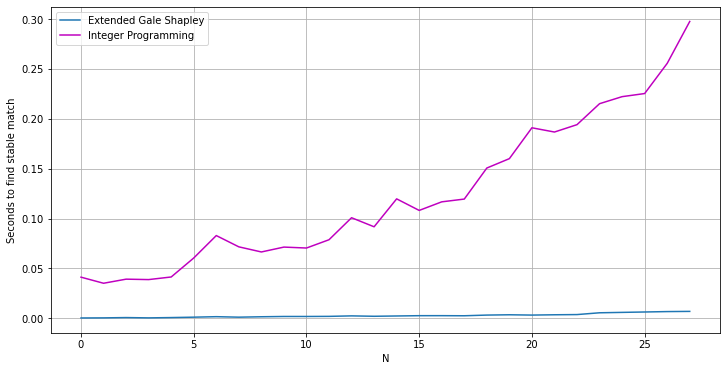

In [1036]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(np.array(gale_time).reshape(-1,10), axis=1), label='Extended Gale Shapley')
plt.plot(np.mean(np.array(linprog_time).reshape(-1,10), axis=1), label='Integer Programming', color='m')
plt.xlabel('N')
plt.ylabel('Seconds to find stable match')
plt.grid()
plt.legend()

In [1033]:
gale_time2 = []
for N in range(2,200):
    for i in range(20):
        men_preferences = create_random_preferences(N, N, True, True)
        women_preferences = create_random_preferences(N, N, True, True)
        start = time.time()
        matching2 = stable_marriage2(men_preferences, women_preferences)
        gale_time2.append(time.time()-start)

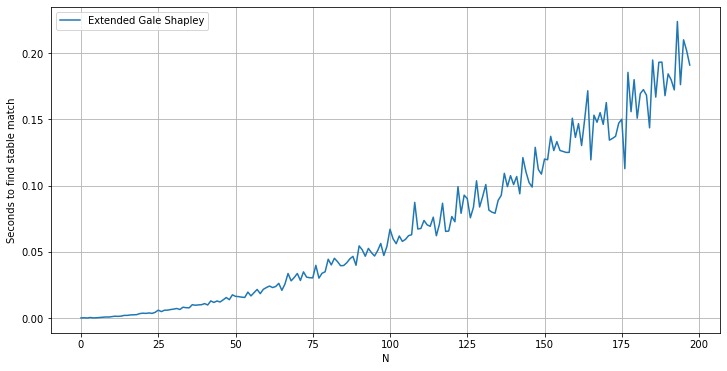

In [1034]:
plt.figure(figsize=(12,6))
plt.plot(np.mean(np.array(gale_time2).reshape(-1,20), axis=1), label='Extended Gale Shapley')
plt.xlabel('N')
plt.ylabel('Seconds to find stable match')
plt.grid()
plt.legend()

In [1070]:
sizes1 = []
sizes2 = []
for N in range(2,30):
    print(N)
    for i in range(5):
        men_preferences = create_random_preferences(N, N, True, True)
        women_preferences = create_random_preferences(N, N, True, True)
        model1, variables1 = IP_MAX_SMTI(men_preferences, women_preferences)
        model2, variables2 = IP_MIN_SMTI(men_preferences, women_preferences)
        model1.solve(solver)
        model2.solve(solver)
        sizes1.append(np.round(model1.objective.value(),4))
        sizes2.append(np.round(model2.objective.value(),4))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


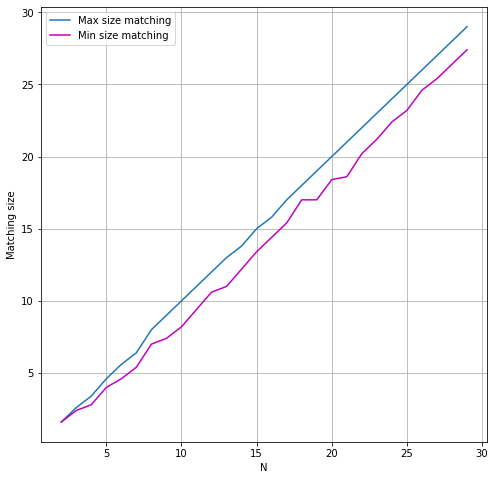

In [1073]:
N = list(range(2,30))
plt.figure(figsize=(8,8))
plt.plot(N,np.mean(np.array(sizes1).reshape(-1,5), axis=1), label='Max size matching')
plt.plot(N,np.mean(np.array(sizes2).reshape(-1,5), axis=1), label='Min size matching', color='m')
plt.xlabel('N')
plt.ylabel('Matching size')
plt.grid()
plt.legend()

In [1082]:
sizes1 = []
sizes2 = []
for N in range(2,30):
    print(N)
    for i in range(10):
        men_preferences = create_random_preferences(N, N, True, True)
        women_preferences = create_random_preferences(N, N, True, True)
        model1, variables1 = IP_MAX_SMTI(men_preferences, women_preferences)
        model2, variables2 = IP_MIN_SMTI(men_preferences, women_preferences)
        model1.solve(solver)
        model2.solve(solver)
        sizes1.append(np.round(model1.objective.value(),4))
        sizes2.append(np.round(model2.objective.value(),4))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


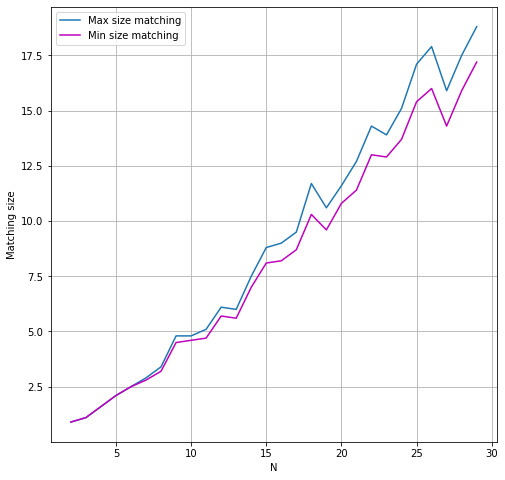

In [1083]:
N = list(range(2,30))
plt.figure(figsize=(8,8))
plt.plot(N,np.mean(np.array(sizes1).reshape(-1,10), axis=1), label='Max size matching')
plt.plot(N,np.mean(np.array(sizes2).reshape(-1,10), axis=1), label='Min size matching', color='m')
plt.xlabel('N')
plt.ylabel('Matching size')
plt.grid()
plt.legend()